In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
MIN_TEHTA = 0
MAX_THETA = 360
THETA_STEP = 45
MIN_THRESH = 150
MAX_THRESH = MIN_THRESH*3
scale_lst = [0.7,0.8,0.9,1,1.1,1.2]

In [52]:

def convolution(image, filter):
    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape

    # padding to preserve the dimension of output
    padding_height = filter_height // 2
    padding_width = filter_width // 2
    padded_image = np.pad(image, ((padding_height, padding_height), (padding_width, padding_width)), mode='constant')
    output = np.zeros_like(image)

    # convolution
    for i in range(image_height):
        for j in range(image_width):
            output[i, j] = np.sum(padded_image[i:i+filter_height, j:j+filter_width] * filter)
    return output

def sobel_filter(image):
    # sobel filter
    filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    # calculate horizontal and vertical gradient of image
    new_image_x = convolution(image, filter)
    new_image_y = convolution(image, np.flip(filter.T, axis=0))

    return new_image_x, new_image_y

def gradient_orientation(image):
    # calculate the gradient given horizontal and vertical images
    dx, dy = sobel_filter(image)
    orientation = (np.arctan2(dy, dx) * 180 / np.pi) % 360  # normalize to [0, 360) degrees

    return orientation

def build_r_table(image, center):
    edges = cv2.Canny(image, MIN_THRESH, MAX_THRESH)
    gradient = gradient_orientation(edges)  # orientation
    r_table = defaultdict(list)

    # build a R-table
    for (i, j), value in np.ndenumerate(edges):
        if value:
            # Calculate the rotation and scale invariant distance and angle
            r = np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
            phi = (np.arctan2(center[0] - i, center[1] - j) - np.radians(gradient[i, j])) % (2 * np.pi)  # normalize to [0, 2*pi) radians
            r_table[gradient[i, j]].append((r, phi))

    return r_table

def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    return boxes[pick].astype("int")

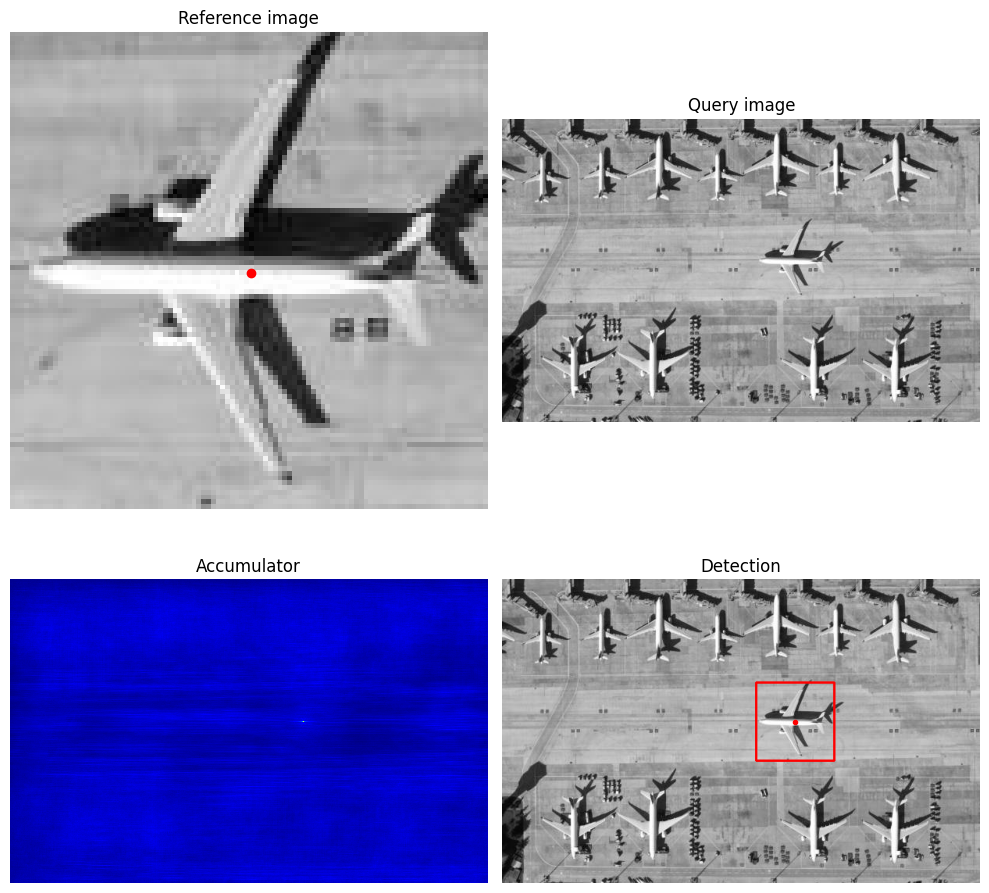

In [48]:
def accumulate_gradients(r_table, grayImage):
    edges = cv2.Canny(grayImage,0,360)
    gradient = gradient_orientation(edges)
    
    accumulator = np.zeros(grayImage.shape)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i,j]]:

                # retrieve the information of reference point from R-table
                accum_i, accum_j = i+r[0], j+r[1]
                accum_i, accum_j = int(accum_i), int(accum_j)

                # majority votes
                if accum_i < accumulator.shape[0] and accum_j < accumulator.shape[1]:
                    accumulator[accum_i, accum_j] += 1
                    
    return accumulator

def main():
    template_image_path = "../hw2/template_image.png"
    target_image_path = "../hw2/target_image.png"

    # Read template and target images
    template_image = cv2.imread(template_image_path, cv2.IMREAD_GRAYSCALE)
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

    # Perform Canny edge detection on template and target images
    template_edges = cv2.Canny(template_image, 50, 150)
    target_edges = cv2.Canny(target_image, 50, 150)

    center = (template_edges.shape[0] // 2, template_edges.shape[1] // 2)
    r_table = build_r_table(template_edges, center)
    accumulator = accumulate_gradients(r_table, target_edges)

    plt.figure(figsize=(10, 10))

    # Plot reference image (template)
    plt.subplot(221)
    plt.imshow(template_image, cmap='gray')
    plt.plot(center[1], center[0], 'ro')
    plt.title('Reference image')
    plt.axis('off')

    # Plot query image (target)
    plt.subplot(222)
    plt.imshow(target_image, cmap='gray')
    plt.title('Query image')
    plt.axis('off')

    # Plot accumulator
    plt.subplot(223)
    plt.imshow(accumulator, cmap='jet')
    plt.title('Accumulator')
    plt.axis('off')

    plt.subplot(224)
    threshold = 0.8 * np.max(accumulator)  # Adjust threshold as needed
    peaks = np.argwhere(accumulator > threshold)
    img_color = cv2.cvtColor(target_image, cv2.COLOR_GRAY2BGR)  # Convert image to color
    all_boxes = []
    for peak in peaks:
        plt.plot(peak[1], peak[0], 'r.')  # Plot peak in reverse order due to numpy array indexing
        tmp_center = (int(peak[1]), int(peak[0]))
        bbox_width = int(template_edges.shape[1])
        bbox_height = int(template_edges.shape[0])
        bbox_x = max(tmp_center[0] - bbox_width // 2, 0)
        bbox_y = max(tmp_center[1] - bbox_height // 2, 0)

        boxes = [bbox_x, bbox_y, bbox_x + bbox_width, bbox_y + bbox_height]
        all_boxes.append(boxes)
        
    nms_boxes = non_max_suppression(np.array(all_boxes),0.5)
    for box in nms_boxes:
        cv2.rectangle(img_color, (box[0],box[1]),(box[2],box[3]),(255,0,0),2)
        
    # Plot detection results (overlay edge template)
    plt.imshow(img_color)
    plt.title('Detection')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    main()

In [50]:
def accumulate_gradients(r_table, grayImage):
    edges = cv2.Canny(grayImage, MIN_THRESH, MAX_THRESH)
    gradient = gradient_orientation(edges)
    accumulator = np.zeros((grayImage.shape[0], grayImage.shape[1], len(scale_lst), len(range(MIN_TEHTA, MAX_THETA, THETA_STEP))), dtype=np.int64)

    for (i, j), value in np.ndenumerate(edges):
        if value:
            for r, phi in r_table[gradient[i, j]]:
                i_p = r*np.cos(phi)
                j_p = r*np.sin(phi)
                for theta in range(MIN_TEHTA, MAX_THETA, THETA_STEP):
                    theta_rad = np.radians(theta)
                    for scale in scale_lst:
                        i_c = int(i - scale*(i_p*np.cos(theta_rad) - j_p*np.sin(theta_rad)))  # calculate the new center (i_c, j_c)
                        j_c = int(j - scale*(i_p*np.sin(theta_rad) + j_p*np.cos(theta_rad)))
                        if 0 <= i_c < grayImage.shape[0] and 0 <= j_c < grayImage.shape[1]:  # check if the new center is within the image
                            accumulator[i_c, j_c, scale_lst.index(scale), theta // THETA_STEP] += 1

    return accumulator

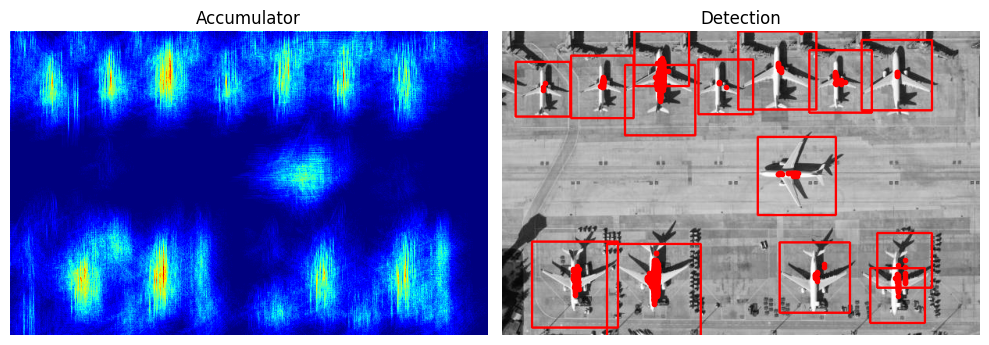

In [65]:
def main():
    template_image_path = "../hw2/template_image.png"
    target_image_path = "../hw2/target_image.png"

    # Read template and target images
    template_image = cv2.imread(template_image_path, cv2.IMREAD_GRAYSCALE)
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

    # Perform Canny edge detection on template and target images
    template_edges = cv2.Canny(template_image,  MIN_THRESH, MAX_THRESH)
    target_edges = cv2.Canny(target_image,  MIN_THRESH, MAX_THRESH)

    center = (template_edges.shape[0] // 2, template_edges.shape[1] // 2)
    r_table = build_r_table(template_edges, center)
    accumulator = accumulate_gradients(r_table, target_image)

    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(accumulator[:,:,0,0], cmap='jet')
    plt.title('Accumulator')
    plt.axis('off')
    # Plot detection results (overlay edge template)
    plt.subplot(122)
    threshold = 0.63 * np.max(accumulator)  # Adjust threshold as needed
    peaks = np.argwhere(accumulator > threshold)

    img_color = cv2.cvtColor(target_image, cv2.COLOR_GRAY2BGR)  # Convert image to color
    all_boxes = []

    for peak in peaks:
        plt.plot(peak[1], peak[0], 'r.')  # Plot peak in reverse order due to numpy array indexing
        scale, rotation = scale_lst[peak[2]], MIN_TEHTA + THETA_STEP*peak[3]

        tmp_center = (int(peak[1]), int(peak[0]))
        bbox_width = int(template_edges.shape[1] * scale)
        bbox_height = int(template_edges.shape[0] * scale)
        bbox_x = max(tmp_center[0] - bbox_width // 2, 0)
        bbox_y = max(tmp_center[1] - bbox_height // 2, 0)

        boxes = [bbox_x, bbox_y, bbox_x + bbox_width, bbox_y + bbox_height]
        all_boxes.append(boxes)
        
    nms_boxes = non_max_suppression(np.array(all_boxes),0.4)

    for box in nms_boxes:
        cv2.rectangle(img_color, (box[0],box[1]), (box[2],box[3]), (255,0,0),2)
        
    plt.imshow(img_color)
    plt.title('Detection')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()